In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

cwd = os.getcwd()
parent_directory = os.path.dirname(cwd)
sys.path.append(parent_directory)


In [3]:
import ipytest
ipytest.autoconfig()

In [4]:
from continualUtils.models import CustomResNet18, PretrainedResNet18, CustomCNN
from continualUtils.explain.tools.harmonizer_loss import NeuralHarmonizerLoss

from continualUtils.evaluation.saliency_map_metrics import show_cam_on_image, rescale_batch
from continualUtils.explain.tools import compute_saliency_map
from continualUtils.explain.tools import (
    compute_pyramidal_mse,
    compute_saliency_map,
    standardize_cut,
)
from torchviz import make_dot
import torch
from torch.utils.data import DataLoader
from conftest import skip_if_no_cuda
from torchvision.utils import make_grid

import torch.nn.functional as F 
import matplotlib.pyplot as plt
from torch.func import functional_call, vmap, grad


/workspaces/continualUtils/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
batch = 10
exp_idx = 1


t_8e23e6c2159445b5be8ff3ca2432e54d.py::test_saliency_map 
------------------------------------------ live log setup ------------------------------------------
DEBUG    pytest:conftest.py:113 Logging setup complete.
------------------------------------------ live log call -------------------------------------------
DEBUG    urllib3.connectionpool:connectionpool.py:546 https://huggingface.co:443 "HEAD /microsoft/resnet-18/resolve/main/config.json HTTP/1.1" 200 0
DEBUG    urllib3.connectionpool:connectionpool.py:546 https://huggingface.co:443 "HEAD /microsoft/resnet-18/resolve/main/config.json HTTP/1.1" 200 0
DEBUG    pytest:2425163384.py:6 taskshape: torch.Size([1])
DEBUG    pytest:2425163384.py:86 tensor(23.6565, device='cuda:0', grad_fn=<MaxBackward1>)
DEBUG    pytest:2425163384.py:87 tensor(23.6565, device='cuda:0')
DEBUG    pytest:2425163384.py:94 pyramidal_loss: 10.225179672241211
PASSED                                                                                       [100%]

=

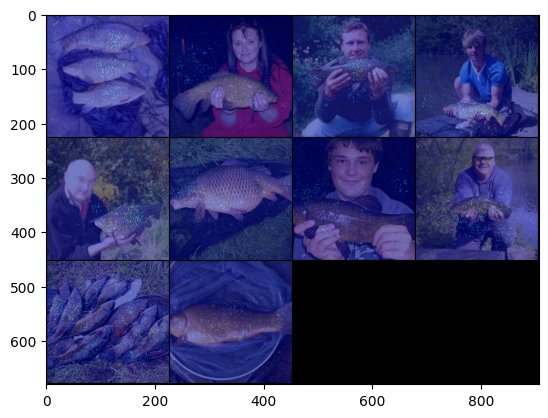

In [22]:
%%ipytest

def compute_score(x, task, y, model, logger=None):
    mb_x = x.unsqueeze(0)
    mb_task = task.unsqueeze(0)
    mb_y = y.unsqueeze(0)

    logger.debug(f"taskshape: {mb_task.shape}")

    mb_pred = model(mb_x, mb_task)
    score = torch.sum(mb_pred * mb_y)
    # logger.debug(f"score: {score}")
    return score


@skip_if_no_cuda
def test_saliency_map(split_clickme_benchmark, logger):
    
    # Build model
    device = torch.device("cuda:0")
    model = PretrainedResNet18(device=device, multihead=False)
    model.model.eval()

    # Get experience
    exp = split_clickme_benchmark.train_stream[exp_idx-1:exp_idx]
    loader = DataLoader(exp[0].dataset, batch_size=batch, shuffle=False)

    # Get batch
    mb_x, mb_y, mb_groundmaps, mb_tokens, mb_tasks =  next(iter(loader))
    
    # Check batch
    assert mb_x.shape == (batch,3,224,224)
    assert mb_y.shape == (batch,)
    assert mb_groundmaps.shape == (batch,1,224,224)
    assert mb_tokens.shape == (batch,)
    assert mb_tasks.shape == (batch,)

    # Prep
    cloned_mb_x = mb_x.detach().to(device)
    if cloned_mb_x.requires_grad is False:
            cloned_mb_x.requires_grad_(True)
    mb_tasks = mb_tasks.to(device)
    mb_tokens = mb_tokens.to(device)
    mb_y_hot = F.one_hot(mb_y.to(device), 1000)
    mb_groundmaps = mb_groundmaps.to(device)

    # Functorch gradient 
    fn_compute_grad = grad(compute_score, argnums=0, has_aux=False)
    fn_compute_sample_grad = vmap(fn_compute_grad, in_dims=(0, 0, 0, None, None))
    per_sample_grad = fn_compute_sample_grad(cloned_mb_x, mb_tasks, mb_y_hot, model, logger)
    per_sample_map = torch.mean(per_sample_grad, dim=1, keepdim=True)
    per_sample_map = F.relu(per_sample_map)

    # Rescale
    per_sample_map = rescale_batch(per_sample_map)
    mb_x = rescale_batch(mb_x)

    # Create grid of overlays
    overlayed = show_cam_on_image(images=mb_x.cpu(), maps=per_sample_map.detach().cpu())
    grid = make_grid(
         overlayed.detach().cpu(),
         normalize=False,
         nrow=4,
    )
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)

    # Standardize cut procedure
    sa_maps_preprocess = standardize_cut(per_sample_map)
    heatmaps_preprocess = standardize_cut(mb_groundmaps)

    # Get max
    with torch.no_grad():
        _sa_max = (
            torch.amax(
                sa_maps_preprocess, dim=(2, 3), keepdim=True
            )
            + 1e-8
        )
        _hm_max = (
            torch.amax(heatmaps_preprocess, dim=(2, 3), keepdim=True)
            + 1e-8
        )

        # Normalize the true heatmaps according to the saliency maps
        heatmaps_preprocess = heatmaps_preprocess / _hm_max * _sa_max

    logger.debug(torch.max(sa_maps_preprocess))
    logger.debug(torch.max(heatmaps_preprocess))

    # Pyramidal loss
    pyramidal_loss = compute_pyramidal_mse(
        sa_maps_preprocess, heatmaps_preprocess, mb_tokens
    )

    logger.debug(f"pyramidal_loss: {pyramidal_loss}")
    dot = make_dot(pyramidal_loss, params=dict(model.named_parameters()))
    # dot.format = 'png'
    # dot.render('manual_graph')




t_8e23e6c2159445b5be8ff3ca2432e54d.py::test_saliency_map_fn 
------------------------------------------ live log setup ------------------------------------------
DEBUG    pytest:conftest.py:113 Logging setup complete.
------------------------------------------ live log call -------------------------------------------
DEBUG    urllib3.connectionpool:connectionpool.py:546 https://huggingface.co:443 "HEAD /microsoft/resnet-18/resolve/main/config.json HTTP/1.1" 200 0
DEBUG    urllib3.connectionpool:connectionpool.py:546 https://huggingface.co:443 "HEAD /microsoft/resnet-18/resolve/main/config.json HTTP/1.1" 200 0
DEBUG    pytest:1433810819.py:82 pyramidal_loss: 10.225178718566895
PASSED                                                                                       [100%]

======================================== 1 passed in 1.02s =========================================


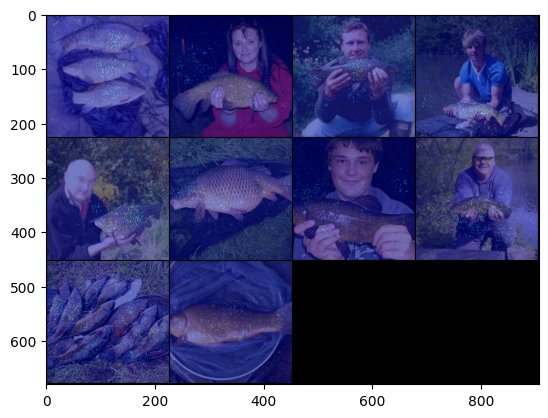

In [24]:
%%ipytest

def compute_score(x, task, y, model):
    mb_x = x.unsqueeze(0)
    mb_task = task.unsqueeze(0)
    mb_y = y.unsqueeze(0)

    # logger.debug(f"taskshape: {mb_task.shape}")

    mb_pred = model(mb_x, mb_task)
    score = torch.sum(mb_pred * mb_y)
    # logger.debug(f"score: {score}")
    return score

@skip_if_no_cuda
def test_saliency_map_fn(split_clickme_benchmark, logger):


    # Build model
    device = torch.device("cuda:0")
    model = PretrainedResNet18(device=device, multihead=False)
    model.model.eval()

    # Get experience
    exp = split_clickme_benchmark.train_stream[exp_idx-1:exp_idx]
    loader = DataLoader(exp[0].dataset, batch_size=batch, shuffle=False)

    # Get batch
    mb_x, mb_y, mb_groundmaps, mb_tokens, mb_tasks =  next(iter(loader))
    
    # Check batch
    assert mb_x.shape == (batch,3,224,224)
    assert mb_y.shape == (batch,)
    assert mb_groundmaps.shape == (batch,1,224,224)
    assert mb_tokens.shape == (batch,)
    assert mb_tasks.shape == (batch,)

    # Prep
    cloned_mb_x = mb_x.detach().to(device)
    if cloned_mb_x.requires_grad is False:
            cloned_mb_x.requires_grad_(True)
    mb_tasks = mb_tasks.to(device)
    mb_tokens = mb_tokens.to(device)
    mb_y = mb_y.to(device)
    mb_groundmaps = mb_groundmaps.to(device)


    harmonizer = NeuralHarmonizerLoss(weight=1)

    # Uses the `__call__` method
    harmonizer_loss = harmonizer(
        cloned_mb_x,
        mb_y,
        mb_groundmaps,
        model,
        mb_tokens,
        mb_tasks,
    )

    # Use function
    mb_y_hot = F.one_hot(mb_y.to(device), 1000)
    fn_sa_maps = compute_saliency_map(
            pure_function=compute_score,
            model=model,
            inputs=cloned_mb_x,
            tasks=mb_tasks,
            targets=mb_y_hot,
        )
     # Rescale
    fn_sa_maps = rescale_batch(fn_sa_maps)
    mb_x = rescale_batch(mb_x)
    
     # Create grid of overlays
    fn_overlayed = show_cam_on_image(images=mb_x.cpu(), maps=fn_sa_maps.detach().cpu())
    grid = make_grid(
         fn_overlayed.detach().cpu(),
         normalize=False,
         nrow=4,
    )
    grid = grid.permute(1, 2, 0)

    plt.imshow(grid)

    logger.debug(f"pyramidal_loss: {harmonizer_loss}")
    # dot = make_dot(harmonizer_loss, params=dict(model.named_parameters()))
    # dot.format = 'png'
    # dot.render('auto_graph')